In [1]:
import logging
import itertools
from prepare_data import HCDALoader
from sklearn.model_selection import KFold

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')


In [2]:
loader = HCDALoader()

# load index values from main table
app_ix = loader.applications_train_index()


2018-06-26 23:01:19,133 - DEBUG - Initializing data loader
2018-06-26 23:01:19,145 - DEBUG - Reading application_train.csv...
2018-06-26 23:01:26,255 - DEBUG - Finished reading application_train.csv
2018-06-26 23:01:26,256 - DEBUG - Loading bureau data...
2018-06-26 23:01:35,179 - DEBUG - Loading previous application data...
2018-06-26 23:02:16,986 - DEBUG - Done


In [4]:
# fit model using k-fold verification
kf = KFold(n_splits=4, shuffle=True)
for fold_indexes in kf.split(app_ix):
    print(fold_indexes[0].shape, fold_indexes[1].shape)
    
data_train, target_train, data_val, target_val = loader.load_train_val(fold_indexes[0], fold_indexes[1])


2018-06-26 23:03:05,032 - DEBUG - Preparing applications data...


(230633,) (76878,)
(230633,) (76878,)
(230633,) (76878,)
(230634,) (76877,)


2018-06-26 23:03:08,389 - DEBUG - Performing soft impute on current home info...
2018-06-26 23:03:17,949 - DEBUG - Running PCA on current home info...
2018-06-26 23:03:20,244 - DEBUG - Performing linear regression on goods price and annuity amount...
2018-06-26 23:03:21,835 - DEBUG - Preparing applications data...
2018-06-26 23:03:22,892 - DEBUG - Performing soft impute on current home info...
2018-06-26 23:03:26,039 - DEBUG - Running PCA on current home info...
2018-06-26 23:03:26,363 - DEBUG - Performing linear regression on goods price and annuity amount...
2018-06-26 23:03:26,399 - DEBUG - Loading training data...
2018-06-26 23:03:32,355 - DEBUG - Loading validation data...
2018-06-26 23:03:35,160 - DEBUG - Scaling train and validation data...
2018-06-26 23:03:38,930 - DEBUG - Done


In [4]:
data_train.shape, target_train.shape, data_val.shape, target_val.shape


((230634, 225), (230634,), (76877, 225), (76877,))

In [5]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
data_train_os, target_train_os = ros.fit_sample(data_train, target_train)


In [6]:
import numpy as np

np.unique(target_train_os, return_counts=True)


(array([0, 1]), array([211976, 211976]))

In [7]:
from models import LinearNN

linear_nn = LinearNN(data_train_os.shape[1], l2_reg=1e-3)
linear_nn.fit(data_train_os, target_train_os, data_val, target_val, num_epochs=5)


Using TensorFlow backend.


Train on 423952 samples, validate on 76877 samples
Epoch 1/5
423952/423952 [==============================] - 26s 62us/step - loss: 0.6169 - acc: 0.6845 - val_loss: 0.6704 - val_acc: 0.6429
Epoch 2/5
423952/423952 [==============================] - 25s 59us/step - loss: 0.5980 - acc: 0.6908 - val_loss: 0.6702 - val_acc: 0.6482
Epoch 3/5
423952/423952 [==============================] - 25s 59us/step - loss: 0.5955 - acc: 0.6940 - val_loss: 0.6264 - val_acc: 0.6759
Epoch 4/5
423952/423952 [==============================] - 26s 61us/step - loss: 0.5942 - acc: 0.6945 - val_loss: 0.6788 - val_acc: 0.6420
Epoch 5/5
423952/423952 [==============================] - 28s 66us/step - loss: 0.5935 - acc: 0.6955 - val_loss: 0.6049 - val_acc: 0.6907


In [8]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.69299958  0.30700042]
 [ 0.33517107  0.66482893]]


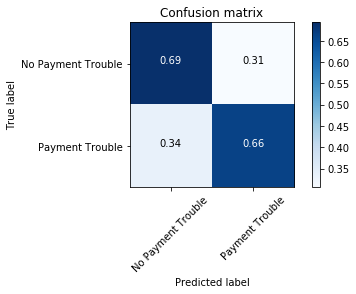

In [9]:
from sklearn.metrics import confusion_matrix

predict_val = linear_nn.predict(data_val)
cm = confusion_matrix(target_val, predict_val.round())
plot_confusion_matrix(cm, ['No Payment Trouble', 'Payment Trouble'], normalize=True)


In [12]:
np.unique(predict_val, return_counts=True), np.unique(predict_val, return_counts=True)

((array([ 0.,  1.], dtype=float32), array([51821, 25056])),
 (array([  4.58533222e-13,   5.61111380e-10,   4.66813299e-09, ...,
           9.99993324e-01,   9.99995232e-01,   9.99995947e-01], dtype=float32),
  array([1, 1, 1, ..., 1, 1, 1])))

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf.fit(data_train_os, target_train_os)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Normalized confusion matrix
[[ 0.99684627  0.00315373]
 [ 0.98135236  0.01864764]]


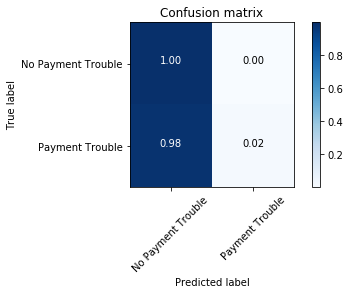

In [16]:
from sklearn.metrics import confusion_matrix

predict_val = clf.predict(data_val)
cm = confusion_matrix(target_val, predict_val.round())
plot_confusion_matrix(cm, ['No Payment Trouble', 'Payment Trouble'], normalize=True)

In [17]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=10)
clf.fit(data_train_os, target_train_os)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=10, random_state=None)

Normalized confusion matrix
[[ 0.68578702  0.31421298]
 [ 0.36873683  0.63126317]]


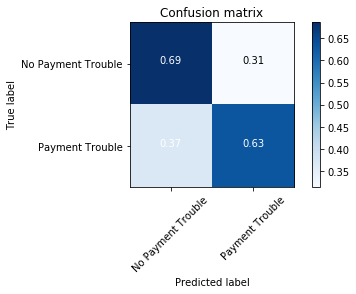

In [18]:
from sklearn.metrics import confusion_matrix

predict_val = clf.predict(data_val)
cm = confusion_matrix(target_val, predict_val.round())
plot_confusion_matrix(cm, ['No Payment Trouble', 'Payment Trouble'], normalize=True)

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=10)
clf.fit(data_train_os, target_train_os)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Normalized confusion matrix
[[ 0.65047377  0.34952623]
 [ 0.32998216  0.67001784]]


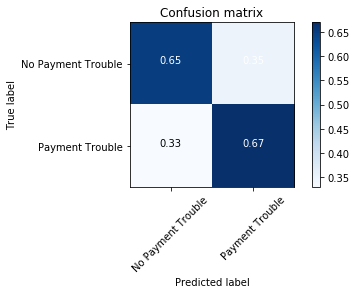

In [20]:
from sklearn.metrics import confusion_matrix

predict_val = clf.predict(data_val)
cm = confusion_matrix(target_val, predict_val.round())
plot_confusion_matrix(cm, ['No Payment Trouble', 'Payment Trouble'], normalize=True)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(data_train_os, target_train_os)

In [ ]:
from sklearn.metrics import confusion_matrix

predict_val = clf.predict(data_val)
cm = confusion_matrix(target_val, predict_val.round())
plot_confusion_matrix(cm, ['No Payment Trouble', 'Payment Trouble'], normalize=True)